# Week 4 Assignment: Saliency 

https://colab.research.google.com/drive/17PtVJuaX6EZBi3GBIvs6X6I5mnx-xIFd

solutions: https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/3-Advance_computer_vision/week-4/C3W4_Assignment.ipynb

Welcome to the final programming exercise of this course! For this week, your task is to adapt the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) Class Activation Map ungraded lab (the second ungraded lab of this week) and make it generate saliency maps instead.

As discussed in the lectures, a saliency map shows the pixels which greatly impacts the classification of an image. 
- This is done by getting the gradient of the loss with respect to changes in the pixel values, then plotting the results. 
- From there, you can see if your model is looking at the correct features when classifying an image. 
  - For example, if you're building a dog breed classifier, you should be wary if your saliency map shows strong pixels outside the dog itself (e.g. sky, grass, dog house, etc...).

In this assignment you will be given prompts but less starter code to fill in in. 
- It's good practice for you to try and write as much of this code as you can from memory and from searching the web.
- **Whenever you feel stuck**, please refer back to the labs of this week to see how to write the code. In particular, look at:
  - **Ungraded Lab 2: Cats vs Dogs CAM**
  - **Ungraded Lab 3: Saliency**




In [1]:
# # Download the same test files from the Cats vs Dogs ungraded lab
# !wget -O training/cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
# !wget -O training/cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
# !wget -O training/catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
# !wget -O training/dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
# !wget -O training/dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

# # Download prepared weights
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kipXTxesGJKGY1B8uSPRvxROgOH90fih' -O training/0_epochs.h5
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oiV6tjy5k7h9OHGTQaf0Ohn3FmF-uOs1' -O training/15_epochs.h5


In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Model
import cv2
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, Input
import os

In [99]:
data = tfds.load('cats_vs_dogs',
                data_dir='/home/mo/tensorflow_datasets',
                as_supervised=True, download=False, split='train')

In [100]:
data

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [101]:
def augmentimages(image, label):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (300,300))
    return image, label

In [102]:
augmented_training_data = data.map(augmentimages)
augmented_training_data

<MapDataset shapes: ((300, 300, 3), ()), types: (tf.float32, tf.int64)>

In [103]:
train_batches = augmented_training_data.shuffle(1024).batch(32)

# train_batches = augmented_training_data.batch(32)
train_batches

<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>

### Build the Cats vs Dogs classifier 

You'll define a model that is nearly the same as the one in the Cats vs. Dogs CAM lab.
* Please preserve the architecture of the model in the Cats vs Dogs CAM lab (this week's second lab) except for the final `Dense` layer.
* You should modify the Cats vs Dogs model at the last dense layer to output 2 neurons instead of 1. 
  - This is because you will adapt the `do_salience()` function from the lab and that works with one-hot encoded labels. 
  - You can do this by changing the `units` argument of the output Dense layer from 1 to 2, with one for each of the classes (i.e. cats and dogs).
  - You should choose an activation that outputs a probability for each of the 2 classes (i.e. categories), where the sum of the probabilities adds up to 1.

In [8]:
# define the model
kernel = (3,3)
act = 'relu'
pad = 'same'
pool = (2,2)

input_layer = Input(shape=(300, 300, 3))

x = Conv2D(16, kernel_size= kernel, activation=act, padding=pad)(input_layer)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(32, kernel_size= kernel, activation=act, padding=pad)(x)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(64, kernel_size= kernel, activation=act, padding=pad)(x)
x = MaxPooling2D(pool_size=pool)(x)

x = Conv2D(128, kernel_size= kernel, activation=act, padding=pad)(x)
x = GlobalAveragePooling2D()(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0     

In [94]:
def do_salience(image_path, model, label, prefix):
    '''
    Generates the saliency map of a given image.

    Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
    '''

    # Read the image and convert channel order from BGR to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image # copy of original image
    original_image_resized = cv2.resize(image, (300,300)) # copy of original image

    # Resize the image to 300 x 300 and normalize pixel values to the range [0, 1]
    image = cv2.resize(image, (300,300)) / 255.0

    # Add an additional dimension (for the batch), and save this in a new variable
    image = np.expand_dims(image, axis=0)
    # print('image shape', image.shape)

    # Declare the number of classes
    num_classes = 2

    # Define the expected output array by one-hot encoding the label
    # The length of the array is equal to the number of classes
    output_onehot =  tf.one_hot([label]*image.shape[0],  num_classes) # this is the ground truth
    print("onehot groundtruth", output_onehot)

    # Within the GradientTape block:
    # Cast the image as a tf.float32
    # Use the tape to watch the float32 image
    # Get the model's prediction by passing in the float32 image
    # Compute an appropriate loss
    # between the expected output and model predictions.
    # you may want to print the predictions to see if the probabilities adds up to 1
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, dtype=tf.float32)
        tape.watch(inputs)
        # this is wrong, because https://pythonshowcase.com/question/how-can-i-compute-gradient-with-tensorflow-keras
        # predictions = model.predict(inputs)
        predictions = model(inputs)
        print("prediction", predictions)
        loss_fn = tf.losses.CategoricalCrossentropy()
        loss = loss_fn(output_onehot, predictions)


    # get the gradients of the loss with respect to the model's input image
    grad = tape.gradient(loss, inputs)

    # generate the grayscale tensor
    gray_tensor = tf.reduce_sum(tf.abs(grad), axis= -1)

    # undo normalization so the pixel values be in the range [0, 255].
    # the max value in the grayscale tensor will be pushed to 255.
    # the min value will be pushed to 0.
    # Use the formula: 255 * (x - min) / (max - min)
    # Use tf.reduce_max, tf.reduce_min
    # Cast the tensor as a tf.uint8
    min = tf.reduce_min(gray_tensor)
    max = tf.reduce_max(gray_tensor)
    normalized_tensor = 255 * (gray_tensor - min)/(max-min)
    normalized_tensor = tf.cast(normalized_tensor, dtype=tf.uint8)

    # Remove dimensions that are size 1
    normalized_tensor = tf.squeeze(normalized_tensor)

    # plot the normalized tensor
    # Set the figure size to 8 by 8
    # do not display the axis
    # use the 'gray' colormap
    # This code is provided for you.
    plt.figure(figsize=(8, 8))
    plt.subplot(1,2,1)
    # plt.axis('off')
    plt.imshow(normalized_tensor, cmap='jet', alpha=0.5)
    plt.imshow(original_image_resized,alpha=0.5)
    plt.title('saliency map over image')
    plt.subplot(1,2,2)
    plt.imshow(normalized_tensor, cmap='gray', alpha=1)
    plt.title('saliency map only')
    plt.show()
    # save the normalized tensor image to a file.
    salient_image_name = os.path.join(prefix, image_path)
    normalized_tensor = tf.expand_dims(normalized_tensor, -1)
    normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
    writer = tf.io.write_file(salient_image_name, normalized_tensor)


### Generate saliency maps with untrained model

As a sanity check, you will load initialized (i.e. untrained) weights and use the function you just implemented. 
- This will check if you built the model correctly and are able to create a saliency map. 

If an error pops up when loading the weights or the function does not run, please check your implementation for bugs.
- You can check the ungraded labs of this week.

Please apply your `do_salience()` function on the following image files:

* `cat1.jpg`
* `cat2.jpg`
* `catanddog.jpg`
* `dog1.jpg`
* `dog2.jpg`

Cats will have the label `0` while dogs will have the label `1`. 
- For the catanddog, please use `0`. 
- For the prefix of the salience images that will be generated, please use the prefix `epoch0_salient`.

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.49321157 0.5067885 ]], shape=(1, 2), dtype=float32)


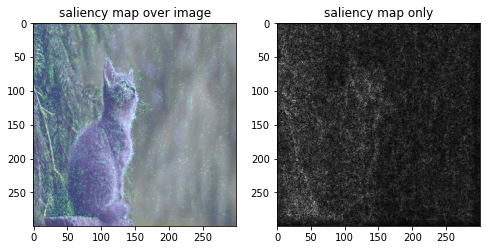

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.4932236 0.5067764]], shape=(1, 2), dtype=float32)


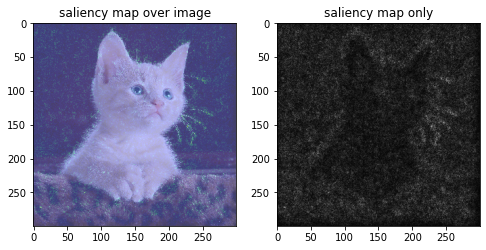

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.4922674  0.50773257]], shape=(1, 2), dtype=float32)


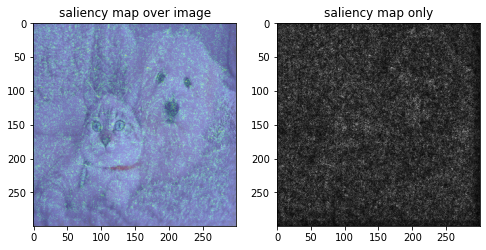

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.49055642 0.5094436 ]], shape=(1, 2), dtype=float32)


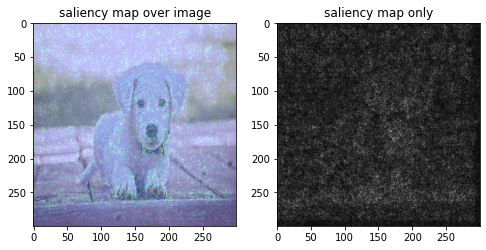

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.49038067 0.50961936]], shape=(1, 2), dtype=float32)


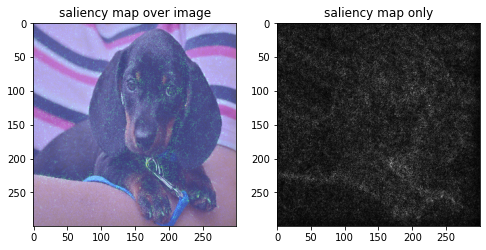

In [88]:
# load initial weights
model.load_weights('training/0_epochs.h5')

# generate the saliency maps for the 5 test images
do_salience('training/cat1.jpg', model, 0, 'epoch0_salient') 
do_salience('training/cat2.jpg', model, 0, 'epoch0_salient') 
do_salience('training/catanddog.jpg', model, 0, 'epoch0_salient')  
do_salience('training/dog1.jpg', model, 1, 'epoch0_salient')  
do_salience('training/dog2.jpg', model, 1, 'epoch0_salient') 


### Configure the model for training

Use `model.compile()` to define the loss, metrics and optimizer. 

* Choose a loss function for the model to use when training. 
  - For `model.compile()` the ground truth labels from the training set are passed to the model as **integers** (i.e. 0 or 1) as opposed to one-hot encoded vectors.
  - The model predictions are class probabilities. 
  - You can browse the [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and determine which one is best used for this case. 
  - Remember that you can pass the function as a string (e.g. `loss = 'loss_function_a'`). 

* For metrics, you can measure `accuracy`. 
* For the optimizer, please use [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop).
  - Please use the default learning rate of `0.001`.

In [89]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


Please pass in the training batches and train your model for just **3** epochs. 
- **Note:** Please do not exceed 3 epochs because the grader will expect 3 epochs when grading your output.
  - After submitting your zipped folder for grading, feel free to continue training to improve your model.

We have loaded pre-trained weights for 15 epochs so you can get a better output when you visualize the saliency maps.

In [104]:
# load pre-trained weights
model.load_weights('training/15_epochs.h5')

# train the model for just 3 epochs
history = model.fit(train_batches, epochs=3)

Epoch 1/3
727/727 [==============================] - 506s 696ms/step - loss: 0.4204 - accuracy: 0.8141
Epoch 2/3
727/727 [==============================] - 500s 687ms/step - loss: 0.3959 - accuracy: 0.8296
Epoch 3/3
727/727 [==============================] - 497s 682ms/step - loss: 0.3837 - accuracy: 0.8344


### We look at Saliency maps again after we loaded the pretrained weights and trained a little bit

We see the image pixels that were most impact-full in the classification. We notice that the model looks at the eyes a lot.

You should see that the strong pixels are now very less than the ones you generated earlier. Moreover, most of them are now found on features within the pet.

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.6116072 0.3883928]], shape=(1, 2), dtype=float32)


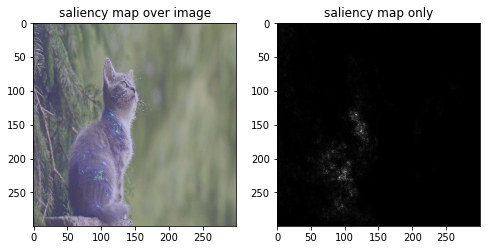

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.42471632 0.57528365]], shape=(1, 2), dtype=float32)


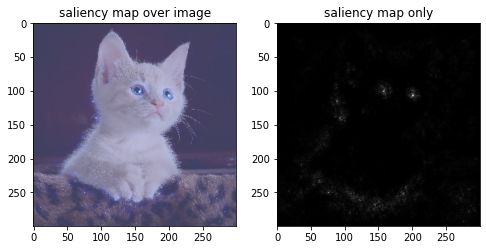

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.3617219  0.63827807]], shape=(1, 2), dtype=float32)


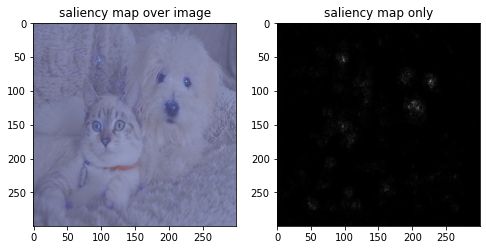

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.33204013 0.66795987]], shape=(1, 2), dtype=float32)


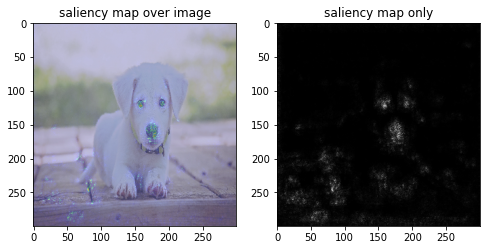

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.20694159 0.7930584 ]], shape=(1, 2), dtype=float32)


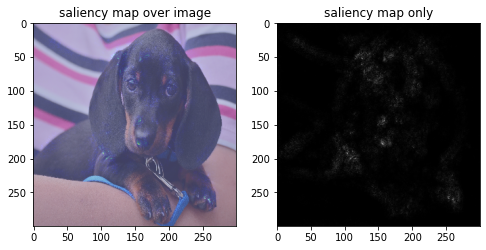

In [105]:
# generate the saliency maps for the 5 test images
do_salience('training/cat1.jpg', model, 0, 'epoch5_salient') 
do_salience('training/cat2.jpg', model, 0, 'epoch5_salient') 
do_salience('training/catanddog.jpg', model, 0, 'epoch5_salient')  
do_salience('training/dog1.jpg', model, 1, 'epoch5_salient')  
do_salience('training/dog2.jpg', model, 1, 'epoch5_salient') 

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.9312337  0.06876634]], shape=(1, 2), dtype=float32)


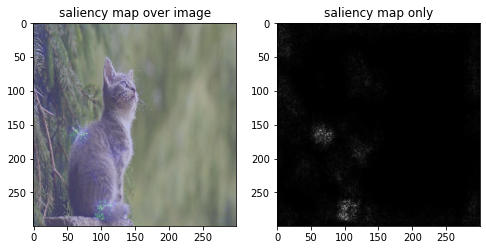

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.9623281 0.0376719]], shape=(1, 2), dtype=float32)


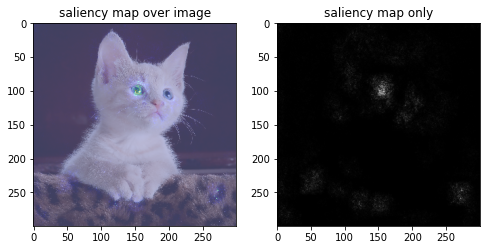

onehot groundtruth tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[0.9900357 0.0099643]], shape=(1, 2), dtype=float32)


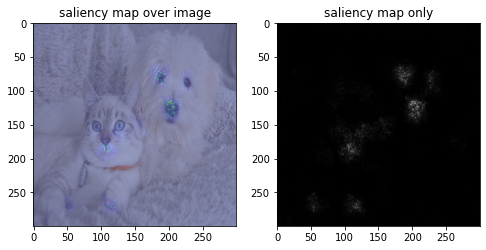

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[1.18794305e-04 9.99881148e-01]], shape=(1, 2), dtype=float32)


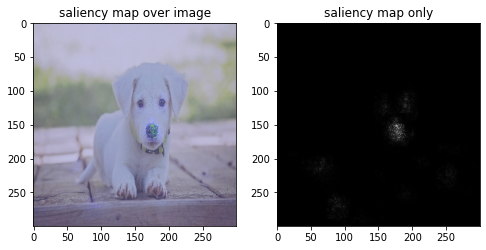

onehot groundtruth tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
prediction tf.Tensor([[8.677418e-05 9.999132e-01]], shape=(1, 2), dtype=float32)


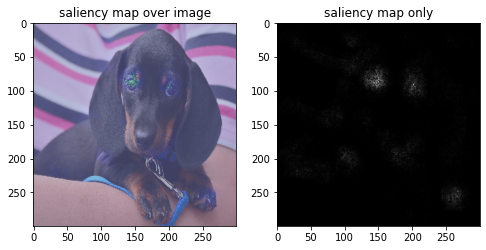

In [107]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=14vFpBJsL_TNQeugX8vUTv8dYZxn__fQY' -O training/95_epochs.h5

model.load_weights('training/95_epochs.h5')

do_salience('training/cat1.jpg', model, 0, 'epoch95_salient') 
do_salience('training/cat2.jpg', model, 0, 'epoch95_salient') 
do_salience('training/catanddog.jpg', model, 0, 'epoch95_salient')  
do_salience('training/dog1.jpg', model, 1, 'epoch95_salient')  
do_salience('training/dog2.jpg', model, 1, 'epoch95_salient') 
